In [1]:
from multiprocessing.managers import Value
%load_ext autoreload
%autoreload 2
from get_class_descriptions import ClassDescriptionsGetter
import json 
import os 
from coco_dataset import COCODataset


In [3]:
dataset = COCODataset(split = 'train')

loading annotations into memory...
Done (t=9.50s)
creating index...
index created!


In [4]:
out = dataset[0]

In [27]:
label_to_category = {key-1: dataset.categories[val] for key, val in dataset.cat_id_to_class_id.items()}

In [28]:
label_to_category

{0: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 1: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 2: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 3: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 4: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 5: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 6: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 7: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 8: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 9: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 10: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 12: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 13: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 14: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 15: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 16: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},


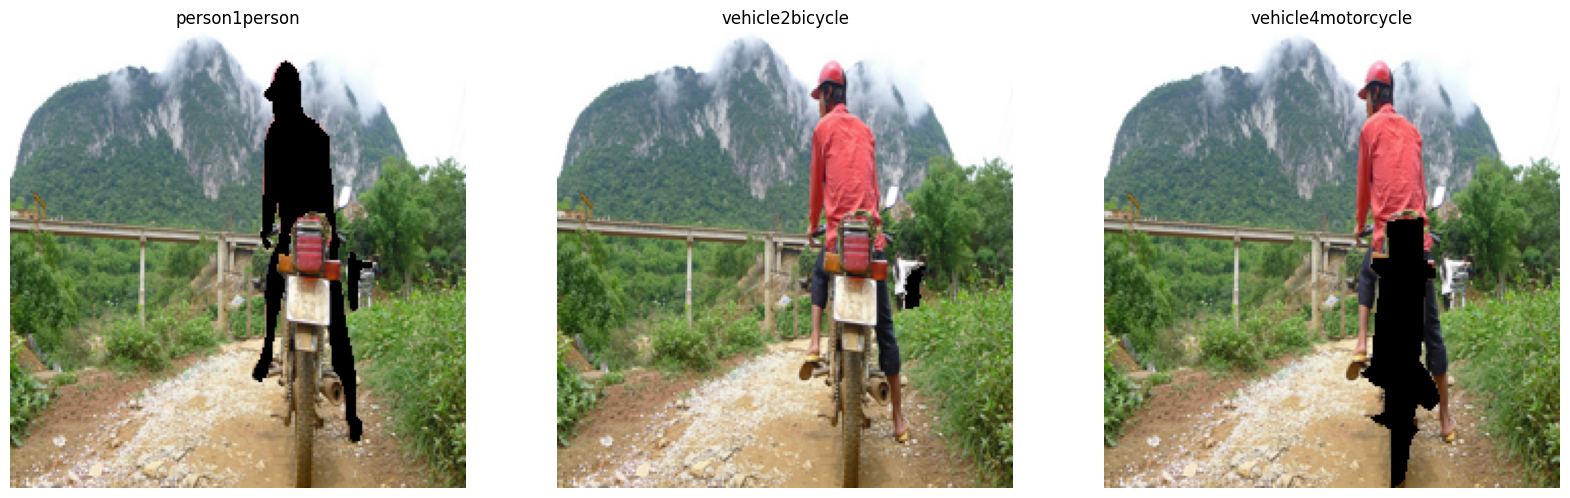

In [34]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
def plot_image_with_classes(out, label_to_category):
    
    class_labels = out['class_labels']
    img = np.asarray(Image.open(out['img_path']).convert('RGB').resize((224, 224)))
    num_plots = len(set(class_labels))
    
    figsize = (20,10)
    if num_plots < 4:
        fig, ax = plt.subplots(1, num_plots, figsize=figsize)
    elif num_plots < 8:
        fig, ax = plt.subplots(2, 4, figsize=figsize)
    else:
        raise ValueError("Too many plots")
    
    class_labels = np.array(class_labels)
    for l, (_, ax_) in zip(np.unique(class_labels), np.ndenumerate(ax)):
        indices = np.where(class_labels == l)[0]
        img_to_plot = img.copy()
        for i in indices:
            label_mask = out['label_mask'][i].numpy().astype(bool)
            img_to_plot[label_mask] = 0
        ax_.imshow(img_to_plot)
        ax_.set_title("".join([str(x) for x in label_to_category[int(l)].values()]))
        ax_.axis('off')
    
    plt.show()
    
plot_image_with_classes(out, label_to_category)

In [37]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import cv2
model_type = 'vit_h'
checkpoint_path = r"C:\Users\pjtka\Documents\COCO\SAM\sam_vit_h_4b8939.pth"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to('cuda')
mask_generator = SamAutomaticMaskGenerator(sam)
image = cv2.imread(out['img_path'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
masks = mask_generator.generate(image)

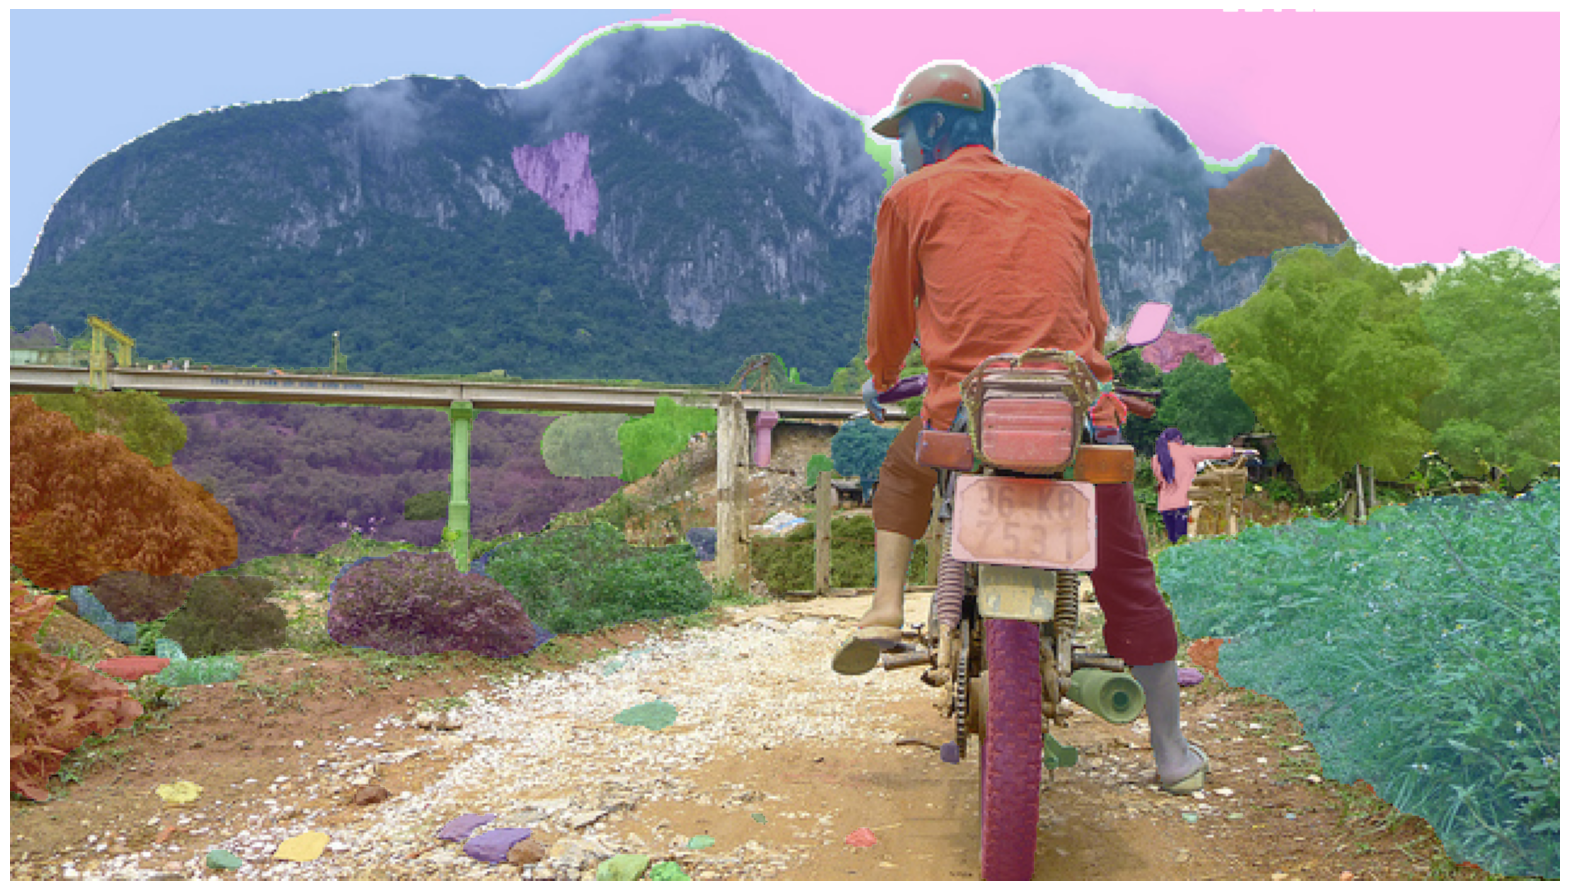

In [40]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [1]:
%load_ext autoreload
%autoreload 2
from dsv_lfs_implementation import DSVLFS


C:\Users\pjtka\PycharmProjects\ConceptBottleneckP2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_type = 'vit_h'
checkpoint_path = r"C:\Users\pjtka\Documents\COCO\SAM\sam_vit_h_4b8939.pth"
model = DSVLFS(model_type, checkpoint_path, device = 'cpu', llm_model_name='llava-hf/llava-1.5-7b-hf')

ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [3]:
# pip install torchao
import torch
from transformers import TorchAoConfig, Gemma3ForConditionalGeneration, AutoProcessor, BitsAndBytesConfig

#quantization_config = TorchAoConfig("int4_weight_only", group_size=128)
quantization_config = BitsAndBytesConfig(load_in_4bit=True)
model = Gemma3ForConditionalGeneration.from_pretrained(
    "google/gemma-3-4b-it",
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    quantization_config=quantization_config
)
processor = AutoProcessor.from_pretrained(
    "google/gemma-3-4b-it",
    padding_side="left"
)

messages = [
    {
        "role": "system",
        "content": [
            {"type": "text", "text": "You are a helpful assistant."}
        ]
    },
    {
        "role": "user", "content": [
            {"type": "image", "url": "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"},
            {"type": "text", "text": "What is shown in this image?"},
        ]
    },
]
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    add_generation_prompt=True,
).to("cuda")

output = model.generate(**inputs, max_new_tokens=50, cache_implementation="static")
print(processor.decode(output[0], skip_special_tokens=True))


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 12.38it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
C:\Users\pjtka\PycharmProjects\ConceptBottleneckP2\.venv\Lib\site-packages\transformers\generation\utils.py:2372: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cuda, whereas the model is on cpu. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cpu') before running `.generate()`.
  warnings.warn(


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [9]:
import json 
with open(os.path.join(getter.outdir, 'class_descriptions.json'), 'w') as f:
    json.dump(descs, f, ensure_ascii=False)


In [12]:
dataset = getter.dataset


In [13]:
dataset.coco.loadImgs(next(iter(dataset.img_ids)))

[{'license': 3,
  'file_name': '000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895}]

In [14]:
img_id = next(iter(dataset.img_ids))
ann_ids = dataset.coco.getAnnIds(imgIds=img_id)
anns = dataset.coco.loadAnns(ann_ids)


In [15]:
anns

[{'segmentation': [[376.97,
    176.91,
    398.81,
    176.91,
    396.38,
    147.78,
    447.35,
    146.17,
    448.16,
    172.05,
    448.16,
    178.53,
    464.34,
    186.62,
    464.34,
    192.28,
    448.97,
    195.51,
    447.35,
    235.96,
    441.69,
    258.62,
    454.63,
    268.32,
    462.72,
    276.41,
    471.62,
    290.98,
    456.25,
    298.26,
    439.26,
    292.59,
    431.98,
    308.77,
    442.49,
    313.63,
    436.02,
    316.86,
    429.55,
    322.53,
    419.84,
    354.89,
    402.04,
    359.74,
    401.24,
    312.82,
    370.49,
    303.92,
    391.53,
    299.87,
    391.53,
    280.46,
    385.06,
    278.84,
    381.01,
    278.84,
    359.17,
    269.13,
    373.73,
    261.85,
    374.54,
    256.19,
    378.58,
    231.11,
    383.44,
    205.22,
    385.87,
    192.28,
    373.73,
    184.19]],
  'area': 12190.44565,
  'iscrowd': 0,
  'image_id': 391895,
  'bbox': [359.17, 146.17, 112.45, 213.57],
  'category_id': 4,
  'id': 151091},
